## Task 2 - Data Analysis

**Name:** Stefan Manek

In this assignment, data acquired from the [Football API](https://www.football-data.org/) is used to compare the percentages of native players in 8 professional European football Leagues in **Analysis 1**, and to develop a prediction model based on prior team performace in **Analysis 2**.

In [27]:
#Importing Libraries
import http.client
import json, requests, urllib
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import time
import numpy as np
from scipy.stats import poisson
import seaborn as sns
import os

The names and API ids for each of the leagues were stored as follows for easy access:

In [3]:
# League IDs for study
league_ids = ['BL1', 'PL', 'ELC', 'PPL', 'SA', 'DED', 'FL1', 'PD']
# The league IDs corresponding to each league name
league_names = {'BL1': 'Bundesliga',
                'PL' : 'Premier League',
                'ELC': 'EFL Championship',
                'PPL': 'Premiera Liga',
                'SA' : 'Seria A',
                'DED': 'Eredivise',
                'FL1': 'Ligue 1',
                'PD' : 'La Liga'}

leagues = []
for id_ in league_ids:
    leagues.append(league_names[id_])

Directory for saving and reading in processed data was defined:

In [4]:
dir_data = Path("Processed Data")
dir_data.mkdir(parents=True, exist_ok=True)

### Analysis 1 - Native Players

The key question of this analysis is simply: 

How do the native player percentages in 8 of the major European football leagues compare?

As the data for the scorers in each league was easily available, this was the first dataset studied.

The file paths of the saved scorer data were grouped together in a dictionary, with league name as the key:

In [5]:
#Placing file paths for each league in dictionary with league names as keys

scorer_data = Path("Raw Data/Scorer Data")

league_files = {}
for id_ in league_ids:
    league_files[league_names[id_]] = []
for fpath in scorer_data.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split("-")
        if parts[0] in league_names.values():
            league_files[parts[0]].append(fpath)

In [6]:
def season_string(file_path):
    """Input: file path for scorer data containing all scorers in a league during one season
    
    Output: Season years in YYYY/YY format, containing start and end years"""
    data = read_json_file(file_path)
    start_year = data['season']['startDate'].split('-')[0]
    end_year = data['season']['endDate'].split('-')[0]
    print(start_year, end_year)
    season_years = "%s/%s" % (start_year, end_year[2:])
    return season_years

def read_json_file(file_path):
    """Simple function to read in JSON data"""
    fin = open(file_path, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    fin.close()
    return data

The scorer data for each league was then organised into csv files with relevant information on each player:

In [7]:
def organise_scorer_data(league_name):
    """Input: Name of league as string
    
    Output: Saves a dataframe including details of all league scorers as a csv in the 
    processed data directory"""
    league_paths = league_files[league_name]
    for fpath in league_paths:
        data = read_json_file(fpath)
        season_year = data['season']['startDate'].split('-')[0]
        rows = []

        for scorer in data['scorers']:
            row = {}
            row['Scorer'] = scorer['player']['name']
            row['Nationality'] = scorer['player']['nationality']
            row['Goals Scored'] = scorer['numberOfGoals']
            row['Position'] = scorer['player']['position']
            row['Country of Birth'] = scorer['player']['countryOfBirth']
            rows.append(row)
        season_df = pd.DataFrame(rows)
        season_df.set_index('Scorer', inplace=True)
        file_name = 'Scorer Data/%s-%s-%s.csv' % (league_name, 'scorers', season_year)
        file_path = dir_data / file_name
        season_df.to_csv(file_path)
    
for league in leagues:
    organise_scorer_data(league)

In [8]:
#Mapping each league to its respective nationality
league_nationalities = {
    'Bundesliga' : 'Germany',
    'Premier League' : 'England',
    'EFL Championship' : 'England',
    'Premiera Liga' : 'Portugal',
    'Seria A' : 'Italy',
    'Eredivise' : 'Netherlands',
    'Ligue 1' : 'France',
    'La Liga' : 'Spain'}

Function was written to parse the scorer csv data and to calculate the percentage of native scorers. The scorer data was placed in dataframe objects, which were in then placed in a dictionary with league names and seasons as keys for easy access:

In [21]:
def native_scorer_percentage(season_df, league_name):
    """Input: scorer dataframe for single season, and name of the league
    
    Output: The percentage of scorer from league's native country"""
    nationalities_series = season_df['Nationality'].value_counts()
    native_nationality = league_nationalities[league_name]
    native_scorers = nationalities_series[native_nationality]
    total_scorers = sum(nationalities_series)
    native_fraction = (native_scorers / total_scorers)*100
    return native_fraction

processed_scorer_data = Path("Processed Data/Scorer Data")

league_dfs = {}
for league in leagues:
    season_dfs = {}
    for season in ['2020', '2021']:
        for filename in os.listdir(processed_scorer_data):
            fpath = os.path.join(processed_scorer_data, filename)
            if (league in fpath) and (season in fpath):
                scorer_df = pd.read_csv(fpath, index_col=0)
                season_dfs[season] = scorer_df
    league_dfs[league] = season_dfs

A sample of the scorer dataframe for the current 2021/22 Bundesliga season is displayed as an example:

In [40]:
league_dfs['Bundesliga']['2021']

,Nationality,Goals Scored,Position,Country of Birth
Scorer,,,,
Robert Lewandowski,Poland,13,Attacker,Poland
Erling Haaland,Norway,9,Attacker,England
Anthony Modeste,France,8,Attacker,France
Patrik Schick,Czech Republic,8,Attacker,Czech Republic
Taiwo Awoniyi,Nigeria,7,Attacker,Nigeria
...,...,...,...,...
Janik Haberer,Germany,1,Midfielder,Germany
Soma Novothny,Hungary,1,Attacker,Hungary
Miloš Pantović,Serbia,1,Attacker,Germany


The native_scorer_percentage function was then used to compute the percentage for each league season, and organised into its own dataframe in a sensible format. This final dataframe was then used to display a bar chart detailing the native scorers in each league across the last two seasons.

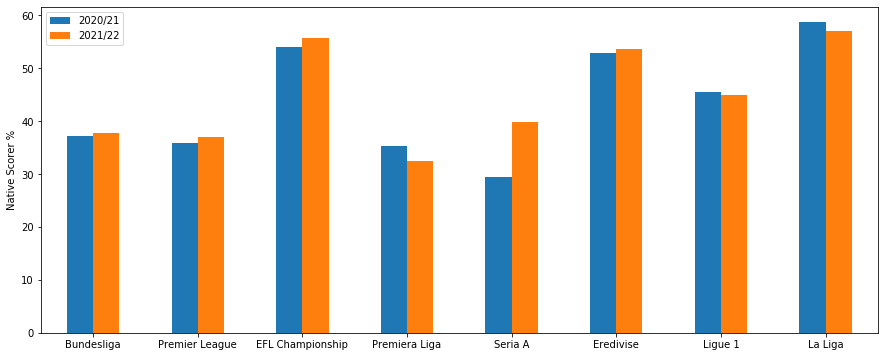

In [42]:
def order_scorer_pctgs(league_names, league_dfs):
    season_2020 = []
    season_2021 = []
    for league in league_names:
        season_dfs = league_dfs[league]
        for season in season_dfs:
            percentage = native_scorer_percentage(season_dfs[season], league)
            if season == '2020':
                season_2020.append(percentage)
            elif season == '2021':
                season_2021.append(percentage)
    df = pd.DataFrame({'2020/21': season_2020,
                   '2021/22': season_2021}, index=league_names)
    return df

new_df = order_scorer_pctgs(leagues, league_dfs)

fig, ax = plt.subplots(1, figsize=(15,6))
ax.set_ylabel('Native Scorer %')
axc = new_df.plot.bar(rot=0, ax=ax)

This bar chart shows some interesting results, with the Portuguese Premiera Liga and the Premier League having the among the lowest native scorer percentages. It was thought that the relatively large percentages in the EFL Championship and Eredivise were due to the poorer quality of the respective leagues, while the high percentage in La Liga is likely due to certain clubs such as Athletic Bilbao having policies of only signing local players. The large increase in the number of Italian scorers in the Serie A was also noteworthy, and expected to be related to the performances of the promoted teams, and is discussed further in the next discussion.

To examine this, the revenues of each league in millions of Euro, were taken from Wikipedia as a rough measure of the quality of each league, and added to the dataframe. These were then displayed on the same graph to see if there was any consistent relationship.

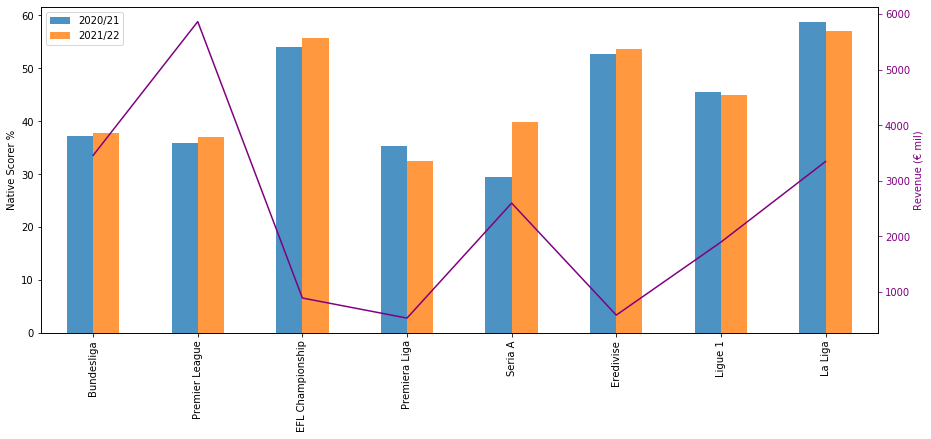

In [66]:
revenues = [3454, 5864, 885.7, 524, 2595, 578, 1892, 3344]
new_df['Revenues'] = revenues

fig, ax = plt.subplots(1, figsize=(15,6))
ax1 = new_df['Revenues'].plot(secondary_y=True, ax=ax, c='purple', label='Revenue')
ax2 = new_df[['2020/21', '2021/22']].plot(kind='bar', ax=ax, alpha=0.8)
ax2.set_ylabel('Native Scorer %')
ax1.set_ylabel('Revenue (€ mil)')

ax1.tick_params(axis='y', colors='purple')
ax1.yaxis.label.set_color('purple')

As shown above, there doesn't appear to be any direct relationship between revenue and native scorer percentage. However, as this was only including the scorers in each league, a similar analysis was conducted for the entire player roster.

In [105]:
roster_df = pd.read_csv("Raw Data/Squads/Bundesliga-players-2020.csv", index_col=0)
roster_df['Bool Col'] = pd.isna(roster_df['Nationality'])
rows_to_remove = roster_df.index[roster_df['Bool Col']].tolist()
roster_df = roster_df.drop(rows_to_remove)
roster_df

native_scorer_percentage(roster_df, 'Bundesliga')

44.77911646586345

As the nationalities of some players was not available from the API database, any players without a nationality value were removed from the dataframe, and the cleaned dataframe was saved in Processed Data:

In [119]:
raw_player_data = Path("Raw Data/Squads")

for filename in os.listdir(raw_player_data):
    fpath = os.path.join(raw_player_data, filename)
    roster_df = pd.read_csv(fpath, index_col=0)
    roster_df['Bool Col'] = pd.isna(roster_df['Nationality'])
    rows_to_remove = roster_df.index[roster_df['Bool Col']].tolist()
    cleaned_df = roster_df.drop(rows_to_remove)
    
    processed_path = os.path.join(dir_data, 'Player Data', filename)
    cleaned_df.to_csv(processed_path)

In [162]:
cleaned_player_data = Path("Processed Data/Player Data")
league_roster_dfs = {}
for league in leagues:
    season_dfs = {}
    for season in ['2020', '2021']:
        for filename in os.listdir(cleaned_player_data):
            if (league in filename) and (season in filename):
                fpath = os.path.join(cleaned_player_data, filename)
                players_df = pd.read_csv(fpath, index_col=0)
                season_dfs[season] = players_df
    league_roster_dfs[league] = season_dfs

In [172]:
league_roster_dfs['Bundesliga']['2020']

,Team,Position,Nationality,Country of Birth,Bool Col
Name,,,,,
Timo Horn,1. FC Köln,Goalkeeper,Germany,Germany,False
Jonas Hector,1. FC Köln,Defender,Germany,Germany,False
Jorge Meré,1. FC Köln,Defender,Spain,Spain,False
Jannes-Kilian Horn,1. FC Köln,Defender,Germany,Germany,False
Salih Özcan,1. FC Köln,Midfielder,Germany,Germany,False
...,...,...,...,...,...
Mohamed Simakan,RB Leipzig,Defender,France,France,False
Joško Gvardiol,RB Leipzig,Defender,Croatia,Croatia,False
Hugo Novoa,RB Leipzig,Midfielder,Spain,Spain,False


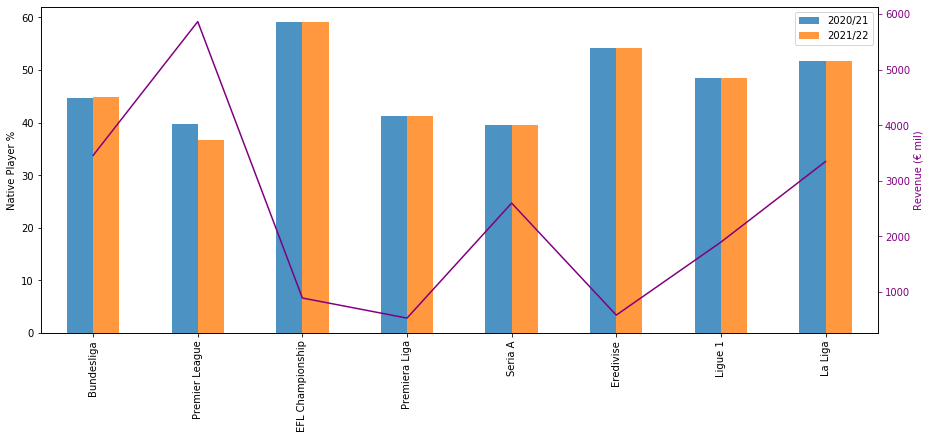

In [164]:
revenues = [3454, 5864, 885.7, 524, 2595, 578, 1892, 3344]
player_pctg_df['Revenues'] = revenues

fig, ax = plt.subplots(1, figsize=(15,6))
ax1 = player_pctg_df['Revenues'].plot(secondary_y=True, ax=ax, c='purple', label='Revenue')
ax2 = player_pctg_df[['2020/21', '2021/22']].plot(kind='bar', ax=ax, alpha=0.8)
ax2.set_ylabel('Native Player %')
ax1.set_ylabel('Revenue (€ mil)')

ax1.tick_params(axis='y', colors='purple')
ax1.yaxis.label.set_color('purple')

When considering the full roster of players in each league, it is noteworthy that the league with the lowest native players (Premier League) has the highest revenue, while the two leagues with the highest number of native players (EFL Championship and Eredivise) have two of the lowest revenues. This would suggest that there is some correlation between the wealth of a league and its native player percentage, however this would require further, more thorough analysis to determine with confidence. It should also be noted that the percentage drop between seasons is only significant for the Premier League, which could be investigated by comparing the squads of the promoted and relegated teams.

The increase in Italian scorer percentage between the last two seasons is also not represented in this plot, indicating that it may be linked to the performance of the newly promoted teams which are more likely to have more native players.

## Analysis 2 - Prediction Model

This analysis utilises the saved results of all the Premier League teams from the 2020/21 season, to predict their performance this season using Poisson statistics in a similar manner to how betting odds are estimated.

Firstly, the team names and API IDs for each were extracted from the saved teams data JSON file from the 2020 season:

In [135]:
def get_team_ids(teams_response_dict):
    teams_id_dict = {}
    for team in teams_response_dict['teams']:
        name = team['name']
        id_ = team['id']
        teams_id_dict[name] = id_
    return teams_id_dict

PL_teams = read_json_file('Raw Data/Team Data/PL-2020-teams.json')
PL_ids = get_team_ids(PL_teams)

This IDs dictionary was then used to parse the saved matches files and extract the goals scored and conceded by each team both at home and away:

In [142]:
def get_goal_stats(match_dict, team_id, league_name):
    home_scored = 0
    away_scored = 0
    home_conceded = 0
    away_conceded = 0
    match_no = 0
    for match in match_dict['matches']:
        if match['competition']['name'] == league_name:
            match_no += 1
            if match['homeTeam']['id'] == team_id:
                home_scored += match['score']['fullTime']['homeTeam']
                home_conceded += match['score']['fullTime']['awayTeam']
            elif match['awayTeam']['id'] == team_id:
                away_scored += match['score']['fullTime']['awayTeam']
                away_conceded += match['score']['fullTime']['homeTeam']
    
    return [home_scored, away_scored, home_conceded, away_conceded, match_no]

raw_results_data = Path("Raw Data/Matches")

def get_all_goal_stats(teams_ids_dict):
    team_goals_dict = {}
    for team in teams_ids_dict:
        for filename in os.listdir(raw_results_data):
            if team in filename:
                fpath = os.path.join(raw_results_data, filename)
                team_matches = read_json_file(fpath)
                team_id = teams_ids_dict[team]
                goal_stats = get_goal_stats(team_matches, team_id, 'Premier League')
                team_goals_dict[team] = goal_stats
    return team_goals_dict

team_goals_dict = get_all_goal_stats(PL_ids)

This data was then converted to dataframe format with columns of home and away goals scored and conceded and saved to a csv file in the processed data directory:

In [141]:
teams_df = pd.DataFrame.from_dict(team_goals_dict, orient='index',
                       columns=['HGS', 'AGS',
                                'HGC', 'AGC', 'Matches'])
teams_df.to_csv(dir_data / 'PL_Team_Data.csv')
teams_df

,HGS,AGS,HGC,AGC,Matches
Arsenal FC,24,31,21,18,38
Aston Villa FC,29,26,27,19,38
Chelsea FC,31,27,18,18,38
Everton FC,24,23,28,20,38
Fulham FC,9,18,28,25,38
Liverpool FC,29,39,20,22,38
Manchester City FC,43,40,17,15,38
Manchester United FC,38,35,28,16,38
Newcastle United FC,26,20,33,29,38
Tottenham Hotspur FC,35,33,20,25,38


The calculations for the prediction model is outlined below:

Four parameters are required to predict the result of a game between two teams:
- The Home and Away Attacking strengths of the respective home and away teams
- The Home and Away Defensive strengths of the respective home and away teams

**Home Attacking strength** is defined as :

- Home team's average goals per home game / average home goals per game

While the **Away Attacking strength** is calculated in the same way.

**Home Defensive Strength** is defined as:

- Home team's average goals conceded per home game / number of home games played.

While the **Away Defensive strength** is calculated in a similar way.

The match scoreline may then be predicted in the following way:

**Expected Home Goals:**

- Home team attack strength * away team defence strength * average number of home goals

**Expected Away Goals:**

- Away team attack strength * home team defence strength * average number of away goals

Therefore, the average stats for the Premier League are extracted from the saved teams data csv file using the following function:

In [143]:
teams_df = pd.read_csv('PL_Team_Data.csv', index_col='Team')

def average_stats(team_df):
    tot_matches = sum(team_df['Matches'])/2 #total matches /2 as each team plays each other
    avg_hgs = sum(team_df['HGS'])/(tot_matches)
    avg_ags = sum(team_df['AGS'])/(tot_matches)
    avg_hgc = sum(team_df['HGC'])/(tot_matches)
    avg_agc = sum(team_df['AGC'])/(tot_matches)
    
    avg_stats = {'HGS' : avg_hgs,
                'AGS' : avg_ags,
                'HGC' : avg_hgc,
                'AGC' : avg_agc}
    return avg_stats

average_stats(teams_df)

{'HGS': 1.3526315789473684,
 'AGS': 1.3421052631578947,
 'HGC': 1.3421052631578947,
 'AGC': 1.3526315789473684}

The above definitions of attack and defence strength are hence used in conjunction with the average values to predict the expected scoreline between two specified teams using the following function:

In [146]:
def exp_goals(team_df, home_team, away_team):
    home_team_stats = team_df.loc[home_team]
    away_team_stats = team_df.loc[away_team]
    
    avg_season_stats = average_stats(team_df)
    
    #Number of home and away games is 19 per team
    home_att_strength = (home_team_stats['HGS']/19)/avg_season_stats['HGS']
    home_def_strength = (home_team_stats['HGC']/19)/avg_season_stats['HGC']
    
    away_att_strength = (away_team_stats['AGS']/19)/avg_season_stats['AGS']
    away_def_strength = (away_team_stats['AGC']/19)/avg_season_stats['AGC']
    
    exp_home_goals = home_att_strength*away_def_strength*avg_season_stats['HGS']
    exp_away_goals = away_att_strength*home_def_strength*avg_season_stats['AGS']
    
    score = [exp_home_goals, exp_away_goals]
    return score

Once the expected scoreline is obtained, the probabilitites of each specific scoreline may then be estimated using the Poisson probability mass function, imported from seaborn, with the expected home or away goals as mean values. The following function was written to calculate the probabilities for the home and away goals up to a specified goal value:

In [144]:
def calculate_score_probs(max_goals, exp_home_goals, exp_away_goals):
    home_goal_probs = []
    away_goal_probs = []
    for goal in range(max_goals+1):
        home_goal_probs.append(poisson.pmf(goal, exp_home_goals))
        away_goal_probs.append(poisson.pmf(goal, exp_away_goals))
                               
    score_probs = []
    for home_goal in range(max_goals+1):
        probs = []
        for away_goal in range(max_goals+1):
            result_prob = (home_goal_probs[home_goal] * away_goal_probs[away_goal])*100
            probs.append(result_prob)
        score_probs.append(probs)
    return score_probs

We can display these score probabiilities on a heatmap. Below is such an example, outlining the scoreline probabilities for when Arsenal (home) play Manchester City (away):

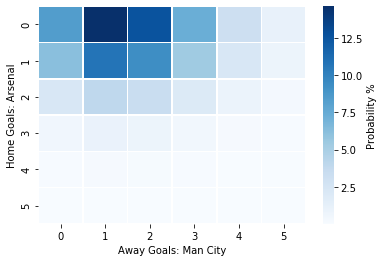

In [153]:
city_arsenal_score = exp_goals(teams_df, 'Arsenal FC', 'Manchester City FC')
exp_scores = calculate_score_probs(5, *city_arsenal_score)

fig, ax = plt.subplots(1)
def score_heatmap(data, home_name, away_name, ax):
    ax = sns.heatmap(data, linewidth=0.5, cmap='Blues', cbar_kws={'label': 'Probability %'}, ax=ax)
    ax.set_ylim(6, 0)
    ax.set_ylabel('Home Goals: %s' % home_name)
    ax.set_xlabel('Away Goals: %s' % away_name)
    return ax
score_heatmap(exp_scores, 'Arsenal', 'Man City', ax)

This shows that the most likely outcome, according to this model is for City to win by a score of 0-1 and appears to be around 13%. 

We can display the specific probability values in a table, marking the results leading to a home win as Red, an away win as cyan, and a draw as white:

In [155]:
def colour_code(df):
    """Function to colour the cells in a dataframe by results"""
    a = np.full(df.shape, '', dtype='<U24')
    for row in range(0,df.shape[0]):
        for column in range(0,df.shape[1]):
            if row > column:
                a[row][column] = 'background-color: red'
            elif column > row:
                a[row][column] = 'background-color: cyan'
            elif row == column:
                a[row][column] = 'background-color: white'
    return pd.DataFrame(a, index=df.index, columns=df.columns)

def display_as_table(score_probs, home_name, away_name):
    goals_list = ['0', '1', '2', '3', '4', '5']
    df = pd.DataFrame(score_probs ,index=pd.Index(goals_list, name='%s Goals' % home_name),
                      columns=pd.MultiIndex.from_product([['%s Goals' % away_name], goals_list]))
    
    return df.style.apply(colour_code, axis=None)

display_as_table(exp_scores, 'Arsenal', 'City')

Therefore, if we add up the probabilities for each corresponding result, we can find the individual probabilities for an Arsenal win, City win and a draw:

In [161]:
def compute_result_probs(score_probs):
    home_win_prob = 0
    away_win_prob = 0
    draw_prob = 0
    for home_goal_val in range(len(score_probs)):
        for away_goal_val in range(len(score_probs)):
            if home_goal_val > away_goal_val:
                home_win_prob += score_probs[home_goal_val][away_goal_val]
            elif away_goal_val > home_goal_val:
                away_win_prob += score_probs[home_goal_val][away_goal_val]
            elif away_goal_val == home_goal_val:
                draw_prob += score_probs[home_goal_val][away_goal_val]
    return [home_win_prob, away_win_prob, draw_prob]

result_probs = compute_result_probs(exp_scores)
print('Percentage Prob. of Arsenal Win: %s' % str(result_probs[0]))
print('Percentage Prob. of City Win: %s' % str(result_probs[1]))
print('Percentage Prob. of Draw: %s' % str(result_probs[2]))

Percentage Prob. of Arsenal Win: 15.513908823666176
Percentage Prob. of City Win: 60.3652190670266
Percentage Prob. of Draw: 23.233765358326252


Hence we can see that an away win for Manchester City is far more likely that Arsenal getting any points, which makes sense considering Manchester City were the league champions last year!

We can examine how well the model performs, considering the most recent round of Premier League fixtures this season. The matchday dictionary was read in as a dictionary from the Raw Data directory and the relevant goals and teams for each fixture were isolated into a csv file which was saved to the Processed directory:

In [165]:
matchday_dictionary = read_json_file('Raw Data/PL_Matchday1_fixtures.json')

def extract_teams(matchday_dict):
    comp = matchday_dict['competition']['code']
    matchday_no = matchday_dict['filters']['matchday']
    matches = matchday_dict['matches']
    home_teams = []
    away_teams = []
    home_gls = []
    away_gls = []
    for fixture in matches:
        home_teams.append(fixture['homeTeam']['name'])
        away_teams.append(fixture['awayTeam']['name'])
        home_gls.append(fixture['score']['fullTime']['homeTeam'])
        away_gls.append(fixture['score']['fullTime']['awayTeam'])
        
    fixtures = {'Home' : home_teams,
                'Home Gls' : home_gls,
                'Away' : away_teams,
                'Away Gls' : away_gls}
    df = pd.DataFrame.from_dict(fixtures)
    
    file_path = 'Processed Data/%s Matchday %s Fixtures.csv' % (comp, matchday_no)
    df.to_csv(file_path)
    return df

teams = extract_teams(matchday_dictionary)

This csv file was then read back in to Python as a dataframe as shown below:

In [170]:
matchday1_df = pd.read_csv('Processed Data/PL Matchday 1 Fixtures.csv', index_col=0)
matchday1_df

,Home,Home Gls,Away,Away Gls
0,Brentford FC,2,Arsenal FC,0
1,Manchester United FC,5,Leeds United FC,1
2,Watford FC,3,Aston Villa FC,2
3,Leicester City FC,1,Wolverhampton Wanderers FC,0
4,Everton FC,3,Southampton FC,1
5,Chelsea FC,3,Crystal Palace FC,0
6,Burnley FC,1,Brighton & Hove Albion FC,2
7,Norwich City FC,0,Liverpool FC,3
8,Newcastle United FC,2,West Ham United FC,4
9,Tottenham Hotspur FC,1,Manchester City FC,0


Using this data, heatmaps of result possibilities were produced for each fixture, with the actual result highlighted by a red X. This allows us to briefly asses the model's performance on a single matchday.

It should be noted that the results for the newly promoted teams could be taken from their championship games last season, which are available on the API. However, as these were in a lower division, they would not be representative of their chances against the stronger teams in the Premier League, and their winning percentages would be inflated. Therefore, results featuring these teams are excluded from this plot. 

Possible further analysis could include devising a relationship between a team's results in the championship and their results upon promotion to the Premier League, or alternatively a promoted team could simply be mapped to a corresponding relegated team from the season prior, assuming that they are of a similar quality.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AE5D7B8588>,
      dtype=object)

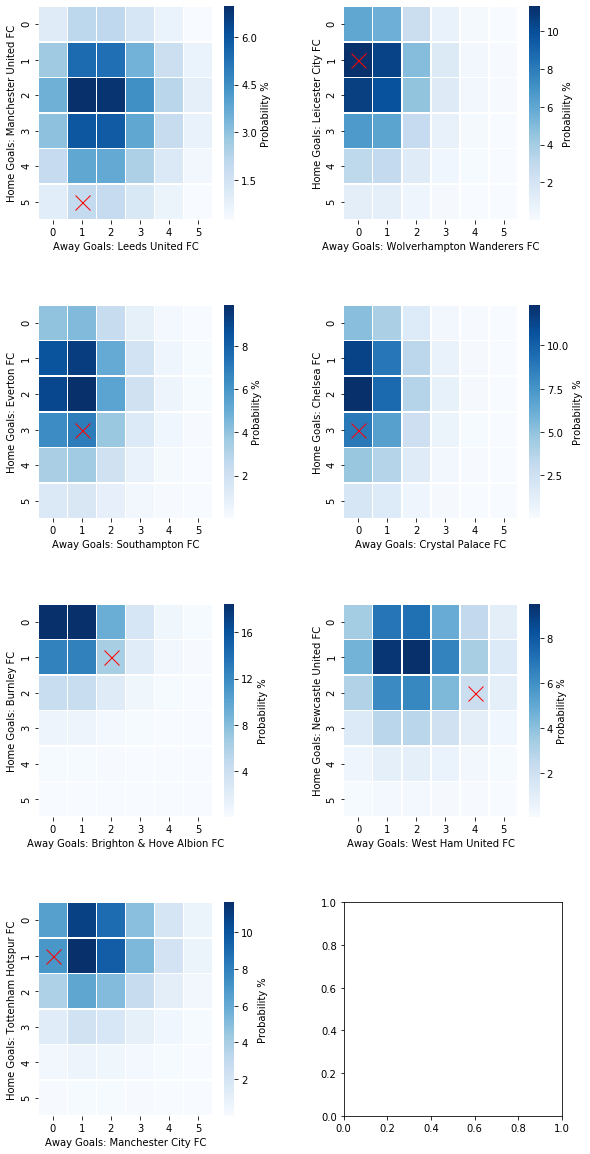

In [171]:
def results_plots(matchday_df, team_df):
    fig, axs = plt.subplots(4,2, figsize=(8, 16))
    fig.tight_layout()
    axs = axs.ravel()
    home_teams = matchday_df['Home']
    away_teams = matchday_df['Away']
    home_gls = matchday_df['Home Gls']
    away_gls = matchday_df['Away Gls']
    
    promoted_teams = ['Brentford FC', 'Watford FC', 'Norwich City FC']
    ax_index = 0
    for index in range(len(home_teams)):
        home = home_teams[index]
        away = away_teams[index]
        if (home not in promoted_teams) and (away not in promoted_teams):
            expected_score = exp_goals(team_df, home, away)
            score_probs = calculate_score_probs(5, *expected_score)
            axs[ax_index] = score_heatmap(score_probs, home, away, axs[ax_index])
            axs[ax_index].plot(away_gls[index]+0.5, home_gls[index]+0.5, 'rx', markersize=15)
            ax_index += 1
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    return axs

results_plots(matchday1_df, teams_df)

As we can see, only in the case of the Leicester vs Wolverhampton match did the most likely predicted result occur. I had planned to examine the performace of the model over a longer period, say, using it to produce a team's points probability over a certain number of games, but unfortunately I ran out of time. This would definitely be the first further investigation to perform if this analysis was to be built upon.

## Conclusions:

In this assignment, two pieces of analysis were conducted relating to a study of the percentages of native players in 8 European football leagues, and a brief prediction model for the scoreline probabilities between two Premier League teams.

One challenge of using the Football-Data API is that the request URL for various different resources are very specific, and so a wide range of request functions were used in Task 1 to acquire all the data required for both analyses.

For **Analysis 1** the native player and scorer percentages across the leagues was investigated, with less wealthy leagues such as the Dutch Eredivise and EFL Championship having relatively higher native players, with the wealthiest Premeir League having the lowest. Data for a larger range of seasons was behind a pay-wall so further analysis could definitiely target getting similar data over a much broader time-frame, where the trends of native player percentages could be investigated. It would be interesting to examine for example, if Brexit has had an effect in the number of foreign players in both the Premier League or Championship, and perhaps if this has lead to other clubs retaining more native players due to stricter work-permit requirements when selling to England.

For **Analysis 2** a rough prediction model was written to estimate the result probability between two teams in the Premier League using data from the 2020/21 season. This was used to display the probabilities and actual scores of the first round of matches from the current season. The model appeared to give an ok representation of the results, however it could easily be expanded on in a number of ways. For example, the model could be tested over an entire season to give a probability distribution for the total points a team will accrue over that season. As this is based on the performace of a team last season, this would give an indication of which teams have improved and which have regressed over time. The model also did not include probabilities for matches involving promoted teams, and devising a method to incorporate these teams, without using their performances in the Championship, into the model would be a clear improvement.